# pygissim

A Tutorial

## What is pygissim?

pygissim is a library for running performance simulations on distributed computer systems. The author works in the area of Geographic Information Systems (GIS) and so the focus here is on Web GIS systems, but the underlying engine is generic and could be used to model many different types of systems that have jobs that are passed from node to node and back to the caller.

pygissim is in its early development, and so there may be need to inspect the code and see how it works. The API documentation is in /docs/_build/html/index.html

The fundamental concept:
1. Create (or load) a Design.
2. Add the Design to a Simulator.
3. Run the Simulator for a length of real-world time.
4. Analyze the results.

This tutorial will take you through each of these steps.

In [30]:
from pygissim.pygissim import *
import pandas as pd
import pygissim.nb as nb
import pygissim.util as util
import matplotlib.pyplot as plt

from yfiles_jupyter_graphs import GraphWidget
from typing import Dict, Tuple

## A Design

A Design contains other collections of objects and has ways to access them:
- Network zones
- Network connections
- Compute nodes
- Service providers
- Workflows

In [31]:
d: Design = Design(name="My Design", desc="An example")

## A Network

First, define network zones. They can be as simple as a single local network, or a web of zones that are interconnected. Zones do not have a specific bandwidth: bandwidth and latency are the job of Connections. A zone will have a local Connection, and Connections that connect it to other Zones.

In [32]:
lan: Zone = Zone(name="LAN", desc="A local zone")
dmz: Zone = Zone(name="DMZ", desc="The edge zone")

Now, let's connect them. Each Zone will have its local Connection and there is a Connection in each direction from lan to dmz and from dmz to lan.

We can add the Zones and Connections to the Design

In [33]:
d.add_zone(lan, local_bw_mbps=1000, local_latency_ms=0)
d.add_zone(dmz, local_bw_mbps=1000, local_latency_ms=0)

# Note that the Connections need not be symmetrical
d.add_connection(lan.connect(dmz, bw=350, lat=1))
d.add_connection(dmz.connect(lan, bw=500, lat=2))

Now, let's visualize the network.

In [34]:
w:GraphWidget = nb.draw_network(d.zones, d.network)
w.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

Note that each Zone is connected to itself (local connection) and has an incoming and outgoing Connection to the other Zone. This means the Zones are fully connected. Zones can connect in many different ways, including branching and looping.

pygissim comes with some template networks. You can list them and load them as shown below.

🌟 **Try it**: copy and paste different network names and re-run below.

In [35]:
print(util.network_list)

['LOCAL_ONLY', 'LOCAL_AND_AGOL', 'BRANCH_OFFICES', 'CLOUDY', 'BACKHAUL_CLOUDY']


In [36]:
d.zones, d.network = util.load_network(util.NetworkNames.LOCAL_AND_AGOL)
w= nb.draw_network(d.zones, d.network)
w.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

### Knowledge Check
1. How many Connections does the Local network Zone have? (Hint: entry, exit and internal)
2. What is the bandwidth from the DMZ to the Internet?
3. What is the bandwidth from the Internet to the DMZ?
4. How many network Connections would a request have to traverse to go from Local to ArcGIS Online?

⚠️ **Before moving on, re-load 'LOCAL_AND_AGOL'** if you changed it

## Adding Compute

The building block for computation is the ComputeNode. They come in three types: clients, physical servers and virtual servers.

**Physical servers** can either host software directly (see Service Providers) and/or be hosts for virtual servers.

**Virtual servers** are hosted by physical servers and have an allocation of CPU and memory from their host. They are used as Service Providers.

**Clients** are abstract and represent a type of device (workstation PC, mobile device) and are used to calculate service times, but not capacity. In real life, every added client to the system scales up the client tier.

All ComputeNodes are located in a Zone.

Every ComputeNode has a HardwareDefinition that describes their overall capacity and performance. You can create a HardwareDefinition from the SPEC.org results here: [https://www.spec.org/cpu2017/results/rint2017/](https://www.spec.org/cpu2017/results/rint2017/).

In [37]:
# If this raises an error, check that you have loaded one of the template networks with a 'Local' zone"
lan: Zone = d.get_zone('Local')

# Creating a Client "by hand"
client_hw = HardwareDef(processor='Intel Core i7-4770K', cores=4, specint_rate2017=20)
client = ComputeNode(name='Client PC', desc='Sample PC',
                     hw_def=client_hw,
                     memory_GB=16,
                     zone=lan,
                     type=ComputeNodeType.CLIENT)

pygissim provides a library of pre-defined hardware for convenience. Check `src/pygissim/data/hardware.csv` for all pre-made types.

In [38]:
# Using the LibManager to create a server. 
lib = util.LibManager()
lib.load_local()
server_hw = lib.hardware['2018 Xeon Gold 6144']
server = ComputeNode(name='Local Server', desc='Physical server',
                     hw_def=server_hw,
                     memory_GB=128,
                     zone=lan,
                     type=ComputeNodeType.P_SERVER)

Virtual servers are hosted on physical servers, so you carve out some of the physical server capacity to create them. You don't need to define hardware, because the physical server provides the definition.

In [39]:
# Virtual machines hosted by the physical server
server.add_virtual_host(name="VMWeb", v_cores=4, memory_GB=8)
server.add_virtual_host(name="VMGISA", v_cores=4, memory_GB=16)
server.add_virtual_host(name="VMGISB", v_cores=4, memory_GB=16)
server.add_virtual_host(name="VMDS", v_cores=4, memory_GB=16)
server.add_virtual_host(name="VMSQL", v_cores=4, memory_GB=16)
server.add_virtual_host(name="VMFile", v_cores=4, memory_GB=16)

d.add_compute(client)
d.add_compute(server)

print(f'Total vCPU allocation: {server.total_vcpu_allocation()}')
print(f'Total memory allocation: {server.total_memory_allocation()} GB out of {server.memory_GB} GB')

Total vCPU allocation: 24
Total memory allocation: 88 GB out of 128 GB


In [40]:
# Some compute power for ArcGIS Online
# If this raises an error, check that you have loaded one of the template networks with a 'ArcGIS Online' zone"
agol: Zone = d.get_zone('ArcGIS Online');

agol_hw = lib.hardware['AMI db.r3.8xlarge (32vc)']
for i in range(1, 4):
    d.add_compute(ComputeNode(f'AGOL{i}','', agol_hw, 128, zone=agol, type=ComputeNodeType.P_SERVER))

Let's visualize the hardware as it relates to the network.
- Orange circles are Zones.
    - In this example, only the Local and ArcGIS Online Zones have ComputeNodes, so Internet and DMZ are unconnected (this isn't a network connectivity graph).
    - The Client PC and local server are in the Local Zone.
    - The AWS servers are in the ArcGIS Online Zone.
- The local physical has several hosted virtual servers.

In [41]:
w = nb.draw_zone_compute(d)
w.graph_layout = "organic"
w.show()

GraphWidget(layout=Layout(height='650px', width='100%'))

### Knowledge Check

1. How many virtual machines are hosted by the Local Server?
2. What network Zone is the Client PC in?
3. How many physical ComputeNodes are in the ArcGIS Online Zone?
4. How many ComputeNodes are in the DMZ?

## Service Providers

Having ComputeNodes is useful, but until they are identified as a ServiceProvider, they won't do anything. Service types are simply a tag that represents a type of service being provided so that when a Workflow Definition says "portal", the system will know what ComputeNodes handle that type.

- ComputeNodes are assigned to ServiceProviders.
- ServiceProviders have a service type (like "portal")

The types of services known by pygissim are defined in `src/pygissim/data/services.csv`

In [42]:
d.services = lib.service_definitions
nb.create_service_provider(d, "Web Browser", service="browser", node_names=['Client PC'], tags={'local'})
nb.create_service_provider(d, "Pro Workstation", service="pro", node_names=['Client PC'], tags={'local'})
nb.create_service_provider(d, "IIS", service="web", node_names=["VMWeb"], tags={'local'})
nb.create_service_provider(d, "Portal", service="portal", node_names=["VMWeb"], tags={'local'})
nb.create_service_provider(d, "Map Server", service="map", node_names=["VMGISA", "VMGISB"], tags={'local'})
nb.create_service_provider(d, "Hosting Server", service="feature", node_names=["VMGISA", "VMGISB"], tags={'local'})
nb.create_service_provider(d, "Data Store", service="relational", node_names=["VMDS"], tags={'local'})
nb.create_service_provider(d, "SQL Server", service="dbms", node_names=["VMSQL"], tags={'local'})
nb.create_service_provider(d, "File Server", service="file", node_names=["VMFile"], tags={'local'})

# ArcGIS Online has a helper function to set up
# All service providers will be tagged with "agol"
nb.create_agol_service_providers(d, agol_zone_name="ArcGIS Online")

To help visualize the relationships between ComputeNodes and ServiceProviders, let's draw them.

🌟 **Try it: hover over the circles, and try playing with the different graph layouts.**

- The dark circles are ServiceProviders.
    - In ArcGIS Online, three physical servers are sharing all of the ServiceProvider duties.
    - Locally, there is a division of Service types to individual virtual hosts.
    - The Hosting Server and Map Server have two load balanced virtual hosts, VMGISA and VMGISB.

In [43]:
# nb.compute_to_graph(d.compute_nodes())
w = nb.draw_compute_sp(d)
w.show()

GraphWidget(layout=Layout(height='760px', width='100%'))

### Knowledge Check

1. What ComputeNode is assigned the "Data Store" service?
2. What services does the Client PC provide?

## Workflows

Here's where the work happens. We need to define work being done by the system and how often it's happening.

As an example, if a user is working with ArcGIS Field Maps, they might have a Web Map loaded that has two layers in it, a base map and an overlay of points. The base map is an example of a cached **map** service and the overlay is an example of a **feature** service.

Making a cached **map** service request will start a chain of operations, with the request going first to the Web Adaptor, then the Portal, GIS Server, and then the File Server to get the tile(s). Then the result is passed up the chain and back to the mobile device. Each hop along the chain might need to traverse one or more network connections.

Setting up workflows "by hand" is a fair bit of code, so using the predefined ones in the library is useful.

In [44]:
# Workflow Definition
viewer_wf_def: WorkflowDef = lib.workflow_definitions['Simple Viewer Web App']
d.add_workflowdef(viewer_wf_def)

# Configured workflow
web_workflow = d.add_client_workflow('Web Workflow', '', wdef_name=viewer_wf_def.name, users=10, productivity=4)

This pre-fab workflow definition sets up two operations that happen when the web user makes a request:
1. The hosted feature layer and
2. The cached base map

These two "chains" of operations (WorkflowChain) can be partly or completely divergent. There can be many chains in parallel. This complexity allows pygissim to simulate the parallel requests that are the norm for modern web maps.

In this case, the requests are similar (same Client, Web server, Portal) until they diverge, with one request needing a hosting server for feature data and the other needing to a map service to get map tiles.

In [45]:
w = nb.draw_workflows(d.all_workflows())
w.show()

GraphWidget(layout=Layout(height='610px', width='100%'))

## Validation

The design now has a network, compute nodes, service providers, and a workflow. But it's not valid.

In [46]:
d.is_valid()

False

In [47]:
d.print_validation_messages()

My Design: "One or more invalid workflows."
Web Workflow: "Workflow Chain Browser Web Hosted is invalid"
Web Workflow: "Workflow Chain Browser Basemap is invalid"
Browser Web Hosted: "Missing service provider for browser"
Browser Web Hosted: "Missing service provider for portal"
Browser Web Hosted: "Missing service provider for web"
Browser Web Hosted: "Missing service provider for feature"
Browser Web Hosted: "Missing service provider for relational"
Browser Basemap: "Missing service provider for browser"
Browser Basemap: "Missing service provider for portal"
Browser Basemap: "Missing service provider for web"
Browser Basemap: "Missing service provider for map"
Browser Basemap: "Missing service provider for file"


The issue is that the **service providers have not been assigned to the steps in the workflow**. The workflow has steps in two chains that specify their type, but no service providers have been assigned, so the chains aren't valid.

In [48]:
viewer_wf_def.missing_service_providers()

['browser', 'portal', 'web', 'feature', 'map', 'file', 'relational']

In [49]:
# Blanket assignment of local service providers
for sp in d.get_service_providers_with_tag('local'):
    viewer_wf_def.assign_service_provider(sp)

# Specify the basemap as coming from ArcGIS Online
basemap_chain = viewer_wf_def.get_chain('Browser Basemap')
for sp in d.get_service_providers_with_tag('agol'):
    basemap_chain.service_providers[sp.service.service_type] = sp

d.is_valid()

True

In [50]:
for chain in viewer_wf_def.chains:
    print(chain.name)
    for step in chain.steps:
        print(f"\t{step.name} -> {chain.service_providers[step.service_type].name}")

Browser Web Hosted
	Client Service 002 -> Web Browser
	Web Service 001 -> IIS
	Portal Service 001 -> Portal
	Hosted Service 001 -> Hosting Server
	Relational Service 001 -> Data Store
Browser Basemap
	Client Service 002 -> Web Browser
	Web Service 001 -> AGOL Edge
	Portal Service 001 -> AGOL Portal
	Map Service 002 -> AGOL Basemap
	File Service 001 -> AGOL File


Now, all of the workflow steps are configured with a service provider. Now we are ready to run the simulator.

## Simulation

Once you have a valid design, it is ready to add to a Simulator.

In [59]:
sim = Simulator("My Simulator", '', design=d)

The steps for running a simulation are:

1. `start` the Simulator: this resets it and makes it ready to create new Transactions over time.
2. Advance time
3. `stop` the Simulator
4. Analyze the results

Trying to start the simulator with an invalid Design will raise an error.

In [60]:
sim.start()
print(f'Simulation clock time: {sim.clock}')
print(f'There are {len(sim.active_requests())} active requests.')
print(f'The first transaction will happen at clock time {sim.next_event_time()} (ms)')

Simulation clock time: 0
There are 0 active requests.
The first transaction will happen at clock time 162 (ms)


If you run the above code multiple times, note that the first transaction time will be at different times. This is because there is a random distribution adjustment function for when requests are made.

You can move time forward by a number of milliseconds, or advance the clock forward to a set time.

In [61]:
sim.advance_time_to(500)
print(sim.clock)
sim.advance_time_by(499)
print(sim.clock)

500
999


At intervals, you should poll all of the queues (Connections and ComputeNodes) to get their utilization.

In [62]:
sim.gather_queue_metrics()

Put this in a loop. The simulation can run for whatever time, but perhaps try a few minutes to start.

In [63]:
# 500 ms times 500 is 250 seconds (4 minutes, 10 seconds)
for i in range(1, 500):
    sim.advance_time_by(500)
    sim.gather_queue_metrics()
    if i % 50 == 0:
        web_workflow.user_count = web_workflow.user_count + 10 # Stepping up the number of users every 50 loops

sim.stop()
print(f'Simulation clock time: {sim.clock}')
print(f'There are {len(sim.active_requests())} active requests.')

Simulation clock time: 250499
There are 23 active requests.


### Visualizing Simulation Results

At this point, there is a large amount of metric data in the Simulator, that we can view using Matplotlib. You can retrieve the metrics either as python objects, or as Pandas dataframes. Dataframes are very useful because you can generate statistics and use them for drawing graphs.

#### Utilization:

Here is a raw Pandas dataframe with statistics for utilization. It's useful to be able to separate out the utilization of network connections, virtual servers and physical servers. 

In [64]:
queue_type = "CONNECTION" # CONNECTION or V_SERVER or P_SERVER
stats = nb.util_stats_for_queues(sim.queue_metrics, queue_type=queue_type)
stats.sort_values(by='Avg')
with pd.option_context("display.float_format", "{:.2%}".format):
    display(stats)

,Queue,Avg,p5,p50,p75,p95,p99
0,ArcGIS Online to ArcGIS Online,1.45%,0.90%,1.40%,1.70%,2.00%,2.20%
1,ArcGIS Online to Internet,0.48%,0.30%,0.50%,0.60%,0.70%,0.70%
2,DMZ to DMZ,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
3,DMZ to Internet,1.45%,0.90%,1.50%,1.80%,2.10%,2.10%
4,DMZ to Local,16.40%,10.20%,17.00%,19.62%,23.20%,25.00%
5,Internet to ArcGIS Online,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
6,Internet to DMZ,16.40%,10.20%,17.00%,19.70%,23.41%,25.10%
7,Internet to Internet,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
8,Local to DMZ,0.48%,0.30%,0.50%,0.60%,0.70%,0.80%
9,Local to Local,35.72%,23.10%,35.65%,41.80%,49.00%,53.60%


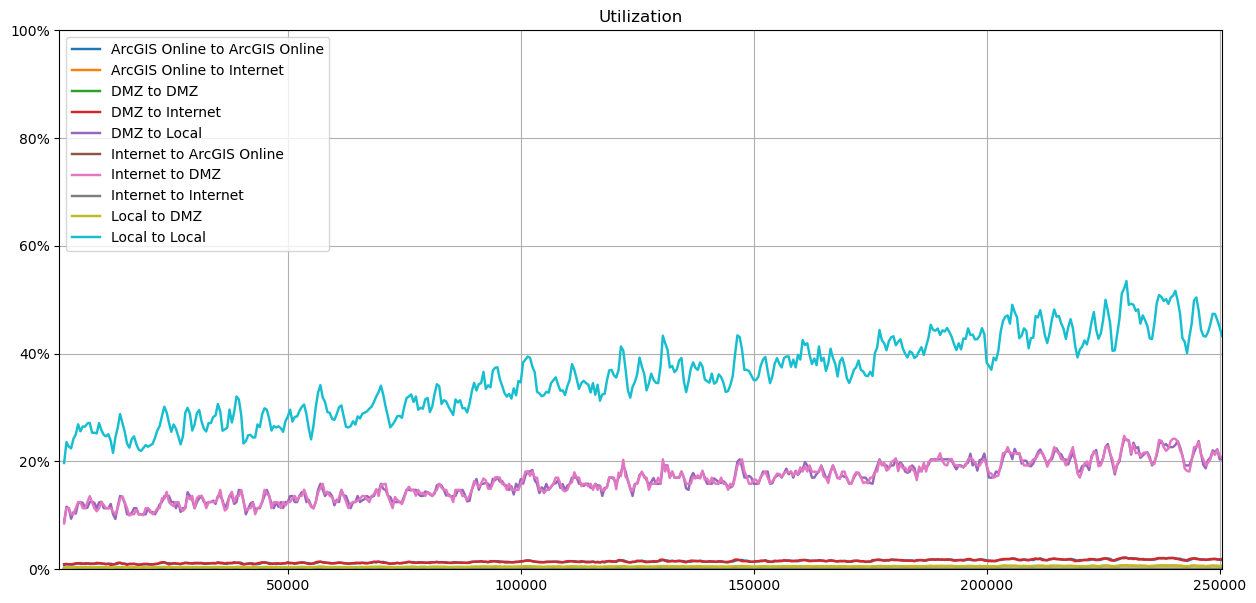

In [65]:
q_util = nb.utilization_for_queues(sim.queue_metrics, queue_type=queue_type)
nb.draw_queue_utilization(q_util, rolling=True)

#### Workflow Performance:

In [66]:
stats = nb.perf_stats_for_requests(sim.request_metrics)
with pd.option_context("display.float_format", "{:,.1f}".format):
    display(stats)

,Workflow,Count,QT_Min,QT_Max,QT_Avg,Net_Avg,Lat_Avg,ST_Avg,RT_Avg,RT_p5,RT_p50,RT_p75,RT_p95,RT_p99
0,Web Workflow,4823,0,64,3.6,75.0,120.0,647.5,846.1,786.0,850.0,900.0,904.0,912.0
